## Inżynieria cech

Łączna liczba zdjęć w zbiorze treningowym: 882
Łączna liczba zdjęć w zbiorze testowym: 37
Łączna liczba zdjęć w zbiorze walidacyjnym: 37


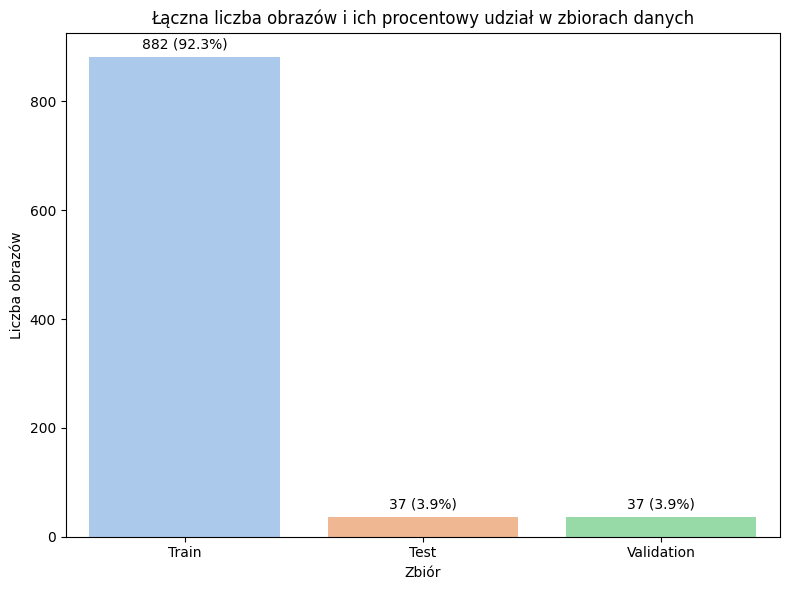

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob

#Sprawdzam czy ramka danych nie uległa zmianie
data_path = 'DATA\\'

# Stworzenie listy dla zbiorów Train, Test, Valid
train_path = os.path.join(data_path, 'Train_Test_Valid', 'Train')
test_path = os.path.join(data_path, 'Train_Test_Valid', 'test')
valid_path = os.path.join(data_path, 'Train_Test_Valid', 'valid')

# Lista klas (typów meduz)
classes = ['barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 
           'lions_mane_jellyfish', 'mauve_stinger_jellyfish', 'Moon_jellyfish']

# Przygotowanie listy plików dla każdej klasy i zbioru (Train, Test, Valid)
train_files = {cls: glob.glob(os.path.join(train_path, cls, '*.jpg')) for cls in classes}
test_files = {cls: glob.glob(os.path.join(test_path, cls, '*.jpg')) for cls in classes}
valid_files = {cls: glob.glob(os.path.join(valid_path, cls, '*.jpg')) for cls in classes}

def total_images_in_dataset(files_dict):
    return sum(len(paths) for paths in files_dict.values())

train_total = total_images_in_dataset(train_files)
test_total = total_images_in_dataset(test_files)
valid_total = total_images_in_dataset(valid_files)
total_all = train_total + test_total + valid_total

print("Łączna liczba zdjęć w zbiorze treningowym:", train_total)
print("Łączna liczba zdjęć w zbiorze testowym:", test_total)
print("Łączna liczba zdjęć w zbiorze walidacyjnym:", valid_total)

total_all = train_total + test_total + valid_total

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({
    'Zbiór': ['Train', 'Test', 'Validation'],
    'Liczba obrazów': [train_total, test_total, valid_total],
})

df['% całości'] = df['Liczba obrazów'] / total_all * 100

plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Zbiór', y='Liczba obrazów', hue='Zbiór', palette='pastel', legend=False)

for i, row in df.iterrows():
    plt.text(i, row['Liczba obrazów'] + total_all * 0.01, 
             f"{row['Liczba obrazów']} ({row['% całości']:.1f}%)", 
             ha='center', va='bottom', fontsize=10)

plt.title('Łączna liczba obrazów i ich procentowy udział w zbiorach danych')
plt.tight_layout()
plt.show()


Przetwarzanie obrazów: 100%|██████████| 956/956 [00:10<00:00, 87.50it/s]

📊 Statystyki zbioru (bez podziału na klasy):


width      height  aspect_ratio  brightness  unique_colors  \
count  956.000000  956.000000         956.0  956.000000     956.000000   
mean   211.620293  211.620293           1.0   86.383785    6070.489540   
std     20.106032   20.106032           0.0   42.036301    1835.821308   
min    179.000000  179.000000           1.0    6.755401    1537.000000   
25%    179.000000  179.000000           1.0   51.276223    4700.500000   
50%    224.000000  224.000000           1.0   83.532435    5975.000000   
75%    224.000000  224.000000           1.0  117.254439    7379.250000   
max    224.000000  224.000000           1.0  226.297473    9902.000000   

               blur  pixel_mean  
count    956.000000  956.000000  
mean    1676.489514   88.581770  
std     1614.476292   40.240873  
min       21.866674    8.375664  
25%      625.462271   56.094659  
50%     1192.091678   86.230407  
75%     2152.679158  117.026391  
max    12035.001968  225.638180

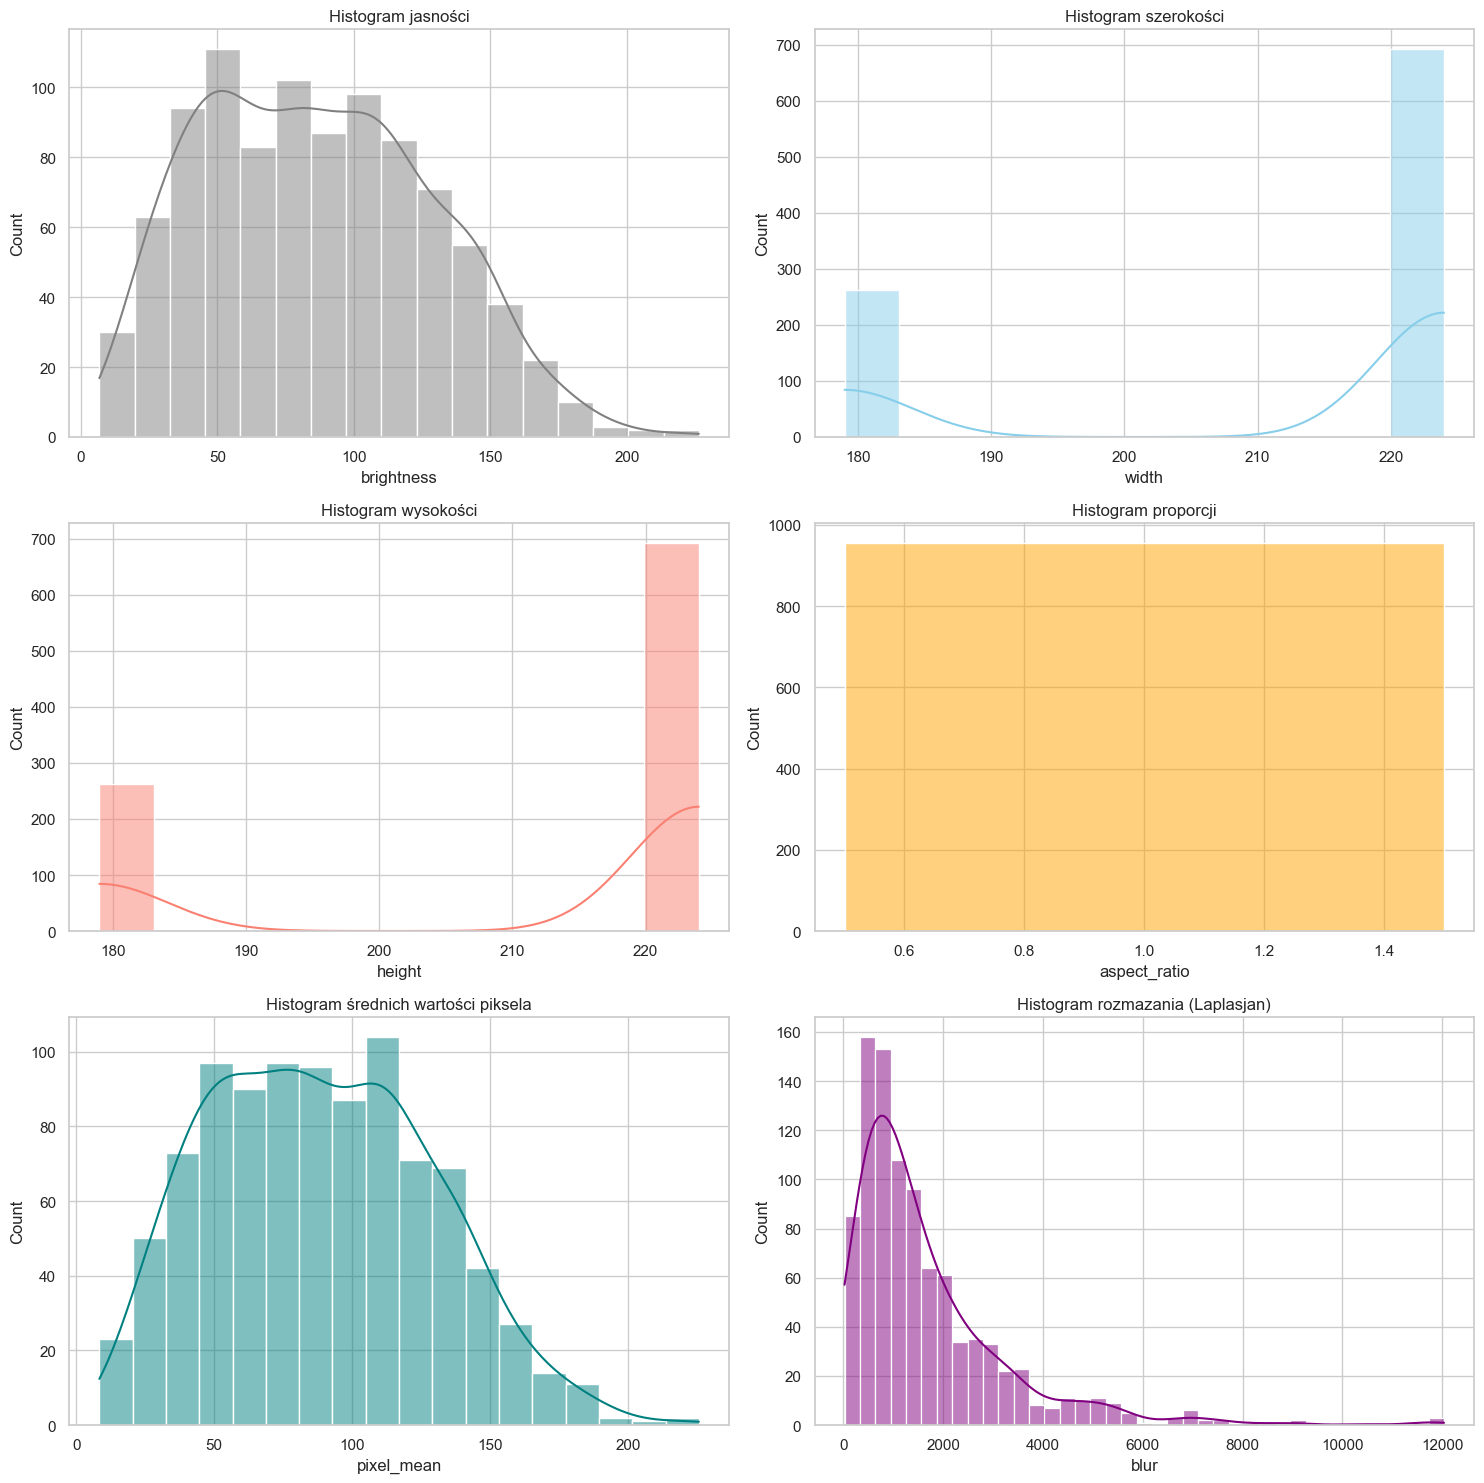

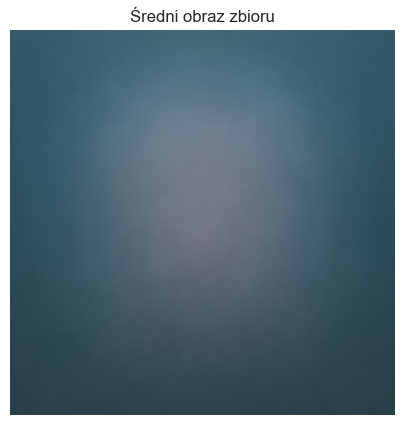

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

# Ścieżki do folderów
train_path = 'DATA/Backup/Train'
test_path = 'DATA/Backup/Test'
valid_path = 'DATA/Backup/Valid'

# Zbieramy wszystkie pliki .jpg w podkatalogach dla wszystkich trzech zbiorów
image_paths = glob.glob(os.path.join(train_path, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(test_path, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(valid_path, '**', '*.jpg'), recursive=True)

# Inicjalizacja
widths, heights, aspect_ratios = [], [], []
brightness_vals, unique_colors, blur_vals = [], [], []
pixel_means = []
hue_hist_total = np.zeros((180, 1))
avg_image = None

# Przetwarzanie obrazów
for path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(path))
    if img is None:
        print(f"Nie można wczytać obrazu: {path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(w / h)
    brightness_vals.append(np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)))

    # Średnia wartość piksela (dla RGB razem)
    pixel_means.append(np.mean(img))

    # Histogram Hue
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue_hist_total += cv2.calcHist([hsv], [0], None, [180], [0, 180])

    # Średni obraz (przeskalowany)
    img_resized = cv2.resize(img, (100, 100))
    if avg_image is None:
        avg_image = np.zeros_like(img_resized, dtype=np.float64)
    avg_image += img_resized / len(image_paths)

    # Unikalne kolory
    unique_colors.append(len(np.unique(img_resized.reshape(-1, 3), axis=0)))

    # Rozmazanie
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    blur_vals.append(cv2.Laplacian(gray, cv2.CV_64F).var())

# Przekształć średni obraz
avg_image = avg_image.astype(np.uint8)
hue_hist_total /= len(image_paths)

# Tworzymy ramkę danych i statystyki
df = pd.DataFrame({
    'width': widths,
    'height': heights,
    'aspect_ratio': aspect_ratios,
    'brightness': brightness_vals,
    'unique_colors': unique_colors,
    'blur': blur_vals,
    'pixel_mean': pixel_means
})

# Statystyki zbioru
print("📊 Statystyki zbioru (bez podziału na klasy):")
display(df.describe())

# Wykresy
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 6 wykresów = 3x2

sns.histplot(df['brightness'], kde=True, ax=axes[0, 0], color='gray').set_title('Histogram jasności')
sns.histplot(df['width'], kde=True, ax=axes[0, 1], color='skyblue').set_title('Histogram szerokości')
sns.histplot(df['height'], kde=True, ax=axes[1, 0], color='salmon').set_title('Histogram wysokości')
sns.histplot(df['aspect_ratio'], kde=True, ax=axes[1, 1], color='orange').set_title('Histogram proporcji')
sns.histplot(df['pixel_mean'], kde=True, ax=axes[2, 0], color='teal').set_title('Histogram średnich wartości piksela')
sns.histplot(df['blur'], kde=True, ax=axes[2, 1], color='purple').set_title('Histogram rozmazania (Laplasjan)')

plt.tight_layout()
plt.show()

# Średni obraz
plt.figure(figsize=(5, 5))
plt.imshow(avg_image)
plt.title("Średni obraz zbioru")
plt.axis('off')
plt.show()


In [13]:
#Zmiana rozmiaru wszystkich zdjęć do 224x224 oraz ich standaryzacja z-score
#Standaryzacja: (img - mean) / std przekształca wartości do rozkładu Z-score, gdzie średnia to 0, a odchylenie standardowe to 1.
#Przywracanie wartości do zakresu 0–255 po standaryzacji jest konieczne, 
#ponieważ standardowe obrazy muszą mieć piksele w tym zakresie, aby mogły być poprawnie zapisane i wyświetlone. 


import os
from pathlib import Path


# Ścieżki wejściowe i wyjściowe
input_base = Path("DATA/Train_Test_Valid")
output_base = Path("DATA/Standardized2_Resized")

# Tworzenie katalogu wyjściowego jeśli nie istnieje
output_base.mkdir(parents=True, exist_ok=True)

# Przetwarzanie zbiorów
for subset in ['Train', 'Test', 'Valid']:
    input_subset = input_base / subset
    output_subset = output_base / subset
    image_paths = list(input_subset.rglob("*.jpg"))

    print(f"\n📁 Przetwarzanie zbioru: {subset} ({len(image_paths)} obrazów)")

    for img_path in tqdm(image_paths):
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"⚠️ Nie można wczytać: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Standaryzacja Z-score
        mean = np.mean(img, axis=(0, 1), keepdims=True)
        std = np.std(img, axis=(0, 1), keepdims=True) + 1e-8  # by uniknąć dzielenia przez 0
        img_std = (img - mean) / std

        # Zmiana rozmiaru na 224x224
        img_resized = cv2.resize(img_std, (224, 224), interpolation=cv2.INTER_LINEAR)

        # Konwersja do 0–255 i uint8 dla zapisu
        img_scaled = np.clip(((img_resized - img_resized.min()) / (img_resized.max() - img_resized.min())) * 255, 0, 255).astype(np.uint8)
        img_bgr = cv2.cvtColor(img_scaled, cv2.COLOR_RGB2BGR)

        # Ścieżka wyjściowa
        relative_path = img_path.relative_to(input_base)
        output_path = output_base / relative_path
        output_path.parent.mkdir(parents=True, exist_ok=True)

        cv2.imwrite(str(output_path), img_bgr)




📁 Przetwarzanie zbioru: Train (882 obrazów)


100%|██████████| 882/882 [00:05<00:00, 167.64it/s]



📁 Przetwarzanie zbioru: Test (37 obrazów)


100%|██████████| 37/37 [00:00<00:00, 163.61it/s]



📁 Przetwarzanie zbioru: Valid (37 obrazów)


100%|██████████| 37/37 [00:00<00:00, 142.11it/s]


Przetwarzanie obrazów:   0%|          | 0/956 [00:00<?, ?it/s]

Przetwarzanie obrazów: 100%|██████████| 956/956 [00:11<00:00, 84.07it/s]

📊 Statystyki zbioru (bez podziału na klasy):


width  height  aspect_ratio  brightness  unique_colors          blur  \
count  956.0   956.0         956.0  956.000000     956.000000    956.000000   
mean   224.0   224.0           1.0   88.213943    6085.075314   1358.345337   
std      0.0     0.0           0.0   40.833791    1812.119418   1296.344037   
min    224.0   224.0           1.0    3.435288    1259.000000     70.084428   
25%    224.0   224.0           1.0   54.893764    4737.500000    533.996000   
50%    224.0   224.0           1.0   89.740623    6053.000000    985.205806   
75%    224.0   224.0           1.0  117.900520    7410.750000   1772.857256   
max    224.0   224.0           1.0  222.027543    9857.000000  10641.842561   

       pixel_mean  
count  956.000000  
mean    88.212352  
std     40.834137  
min      3.530360  
25%     54.868601  
50%     89.745659  
75%    117.902842  
max    222.007700

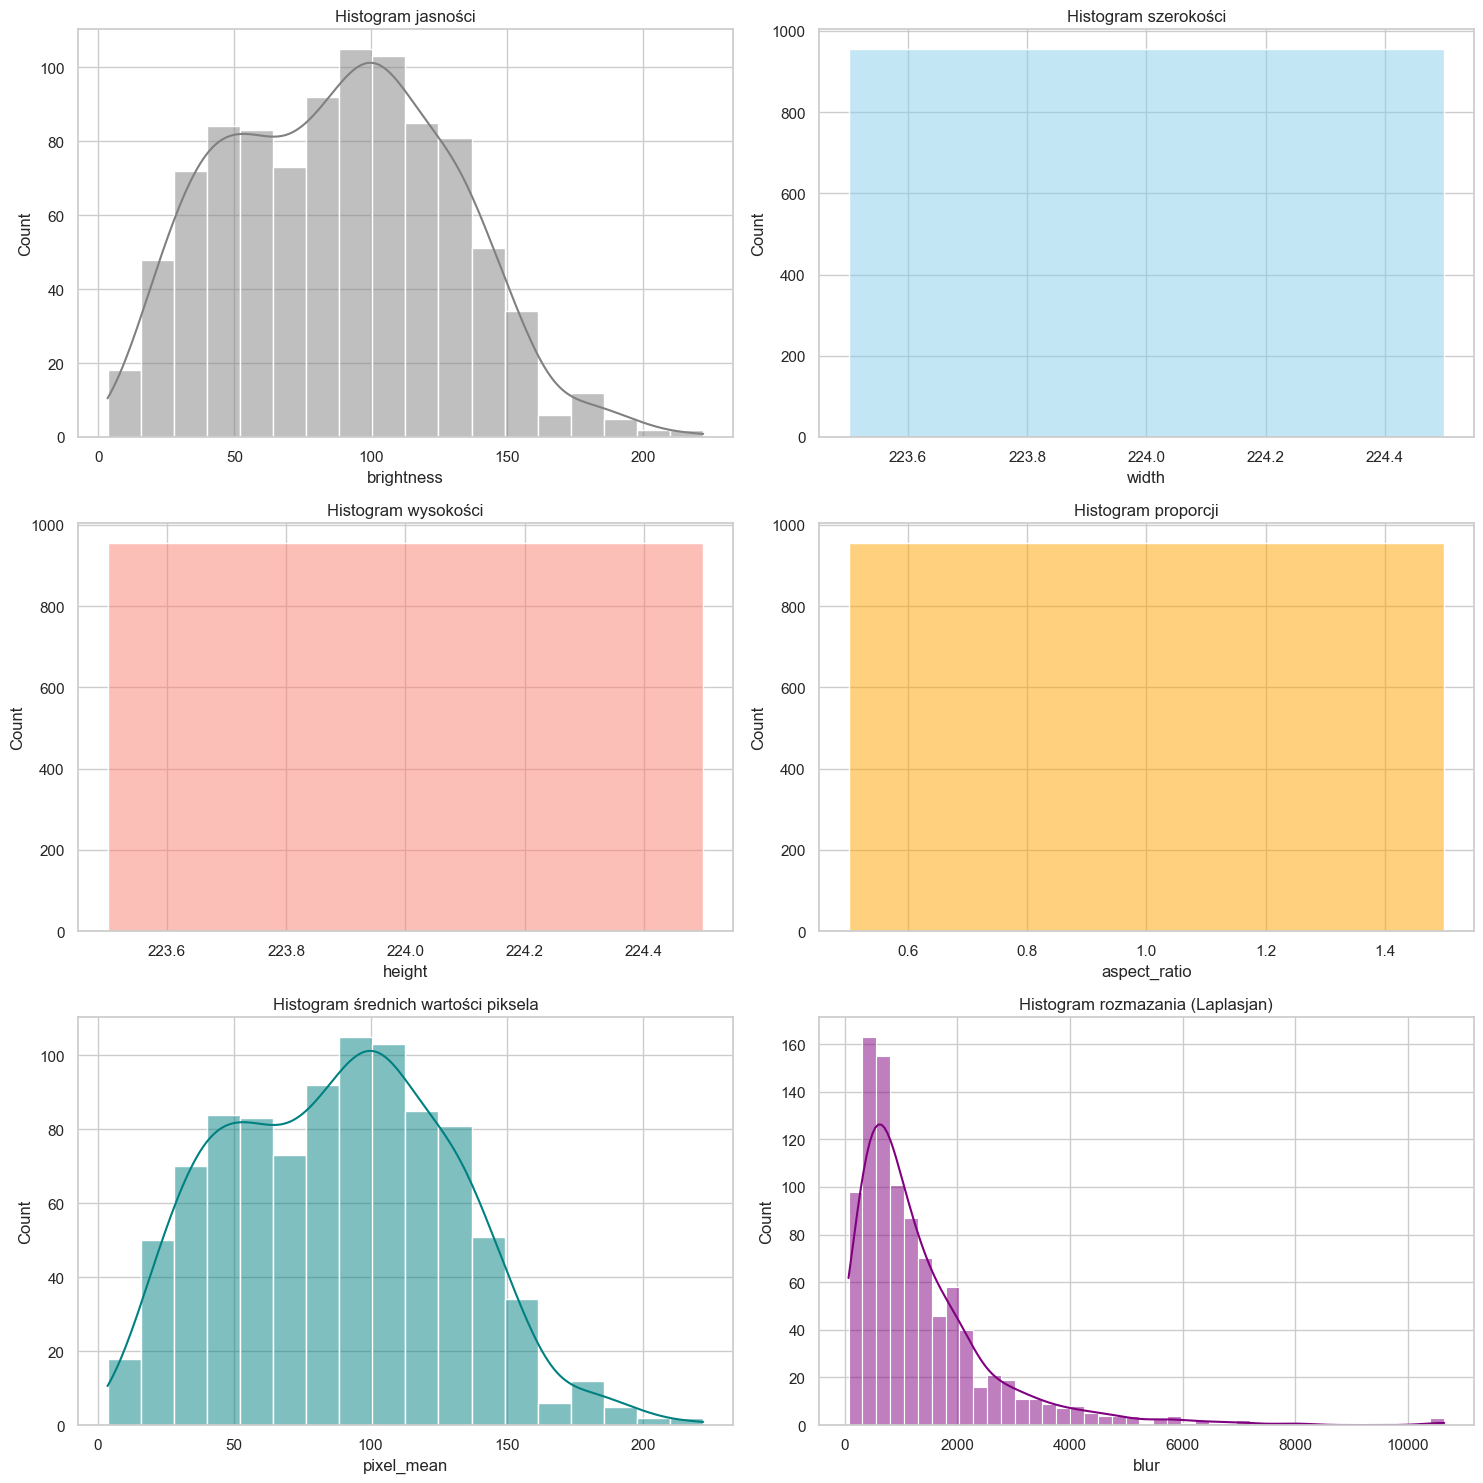

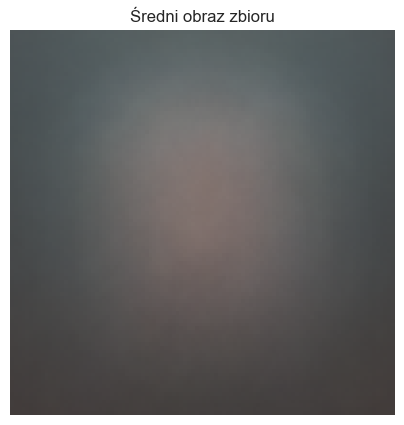

In [18]:
#Zobrazowanie statystyk zbioru po standaryzacji i resizingu
train_path = 'DATA/Standardized2_Resized/Train'
test_path = 'DATA/Standardized2_Resized/Test'
valid_path = 'DATA/Standardized2_Resized/Valid'

# Zbieramy wszystkie pliki .jpg w podkatalogach dla wszystkich trzech zbiorów
image_paths = glob.glob(os.path.join(train_path, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(test_path, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(valid_path, '**', '*.jpg'), recursive=True)

# Inicjalizacja
widths, heights, aspect_ratios = [], [], []
brightness_vals, unique_colors, blur_vals = [], [], []
pixel_means = []
hue_hist_total = np.zeros((180, 1))
avg_image = None

# Przetwarzanie obrazów
for path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(path))
    if img is None:
        print(f"Nie można wczytać obrazu: {path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(w / h)
    brightness_vals.append(np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)))

    # Średnia wartość piksela (dla RGB razem)
    pixel_means.append(np.mean(img))

    # Histogram Hue
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue_hist_total += cv2.calcHist([hsv], [0], None, [180], [0, 180])

    # Średni obraz (przeskalowany)
    img_resized = cv2.resize(img, (100, 100))
    if avg_image is None:
        avg_image = np.zeros_like(img_resized, dtype=np.float64)
    avg_image += img_resized / len(image_paths)

    # Unikalne kolory
    unique_colors.append(len(np.unique(img_resized.reshape(-1, 3), axis=0)))

    # Rozmazanie
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    blur_vals.append(cv2.Laplacian(gray, cv2.CV_64F).var())

# Przekształć średni obraz
avg_image = avg_image.astype(np.uint8)
hue_hist_total /= len(image_paths)

# Tworzymy ramkę danych i statystyki
df = pd.DataFrame({
    'width': widths,
    'height': heights,
    'aspect_ratio': aspect_ratios,
    'brightness': brightness_vals,
    'unique_colors': unique_colors,
    'blur': blur_vals,
    'pixel_mean': pixel_means
})

# Statystyki zbioru
print("📊 Statystyki zbioru (bez podziału na klasy):")
display(df.describe())

# Wykresy
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 6 wykresów = 3x2

sns.histplot(df['brightness'], kde=True, ax=axes[0, 0], color='gray').set_title('Histogram jasności')
sns.histplot(df['width'], kde=True, ax=axes[0, 1], color='skyblue').set_title('Histogram szerokości')
sns.histplot(df['height'], kde=True, ax=axes[1, 0], color='salmon').set_title('Histogram wysokości')
sns.histplot(df['aspect_ratio'], kde=True, ax=axes[1, 1], color='orange').set_title('Histogram proporcji')
sns.histplot(df['pixel_mean'], kde=True, ax=axes[2, 0], color='teal').set_title('Histogram średnich wartości piksela')
sns.histplot(df['blur'], kde=True, ax=axes[2, 1], color='purple').set_title('Histogram rozmazania (Laplasjan)')

plt.tight_layout()
plt.show()

# Średni obraz
plt.figure(figsize=(5, 5))
plt.imshow(avg_image)
plt.title("Średni obraz zbioru")
plt.axis('off')
plt.show()


In [ ]:
#Kopia do oceny skali szarości
import shutil
from pathlib import Path

# Ścieżki
src = Path("DATA/Standardized2_Resized")
dst = Path("DATA/Standardized_Copy")

# Kopiowanie całego katalogu (rekurencyjnie)
shutil.copytree(src, dst, dirs_exist_ok=True)

WindowsPath('DATA/Standardized_Copy')


📁 Przetwarzanie obrazów: (956 obrazów)


Przetwarzanie obrazów: 100%|██████████| 956/956 [00:00<00:00, 996.51it/s] 


Średnia jasność w całym zbiorze: 88.21
Minimalna jasność w zbiorze: 3.44
Maksymalna jasność w zbiorze: 222.03


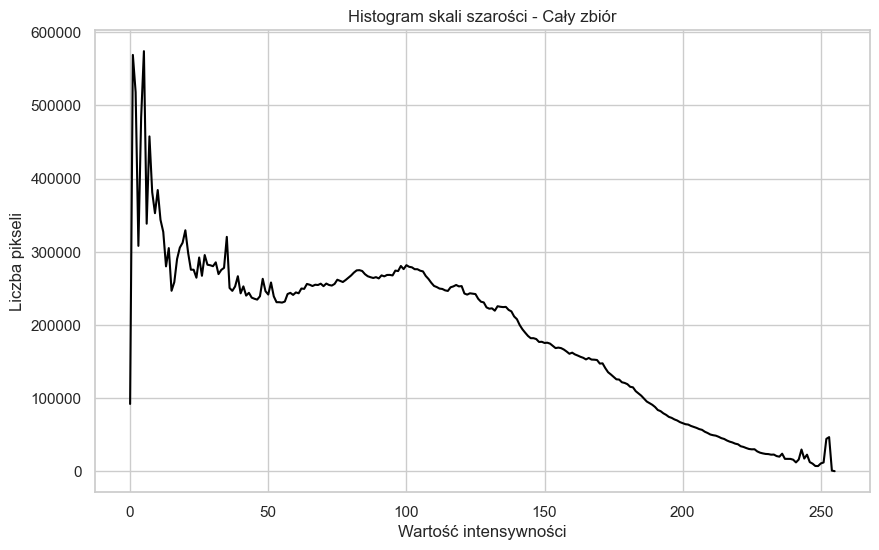

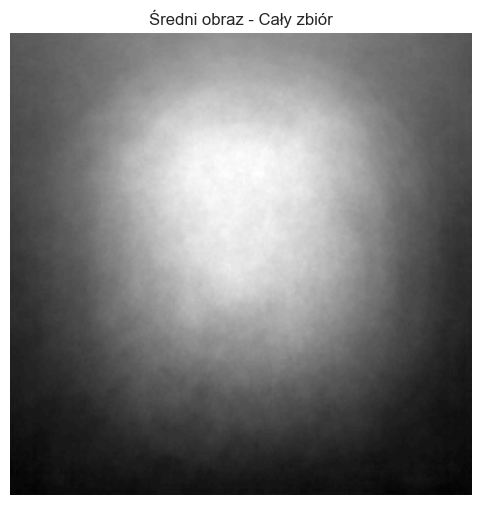

In [20]:
#Skala szarości obrazu to jedna wartość na piksel, która reprezentuje intensywność światła w obrazie, bez informacji o kolorze.

# Ścieżki wejściowe
input_base = Path("DATA/Standardized_Copy")

# Inicjalizacja zmiennych
brightness_vals = []
average_image = None  # Średni obraz dla całego zbioru
gray_hist_total = np.zeros((256, 1))  # Histogram skali szarości (0-255)

# Wyszukaj wszystkie obrazy w katalogu "Standardized" (rekursywnie)
image_paths = list(input_base.rglob("*.jpg"))  # Wyszukaj obrazy .jpg w podkatalogach

print(f"\n📁 Przetwarzanie obrazów: ({len(image_paths)} obrazów)")

# Zmienna do przechowywania minimalnej i maksymalnej jasności
min_brightness = float('inf')
max_brightness = float('-inf')

for img_path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Nie można wczytać: {img_path}")
        continue
    
    # Konwersja do skali szarości
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Obliczanie średniej jasności
    brightness = np.mean(gray_image)
    brightness_vals.append(brightness)

    # Aktualizacja minimalnej i maksymalnej jasności
    min_brightness = min(min_brightness, brightness)
    max_brightness = max(max_brightness, brightness)

    # Histogram skali szarości
    gray_hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    gray_hist_total += gray_hist  # Zbieranie histogramu

    # Obliczanie średniego obrazu
    if average_image is None:
        average_image = np.zeros_like(gray_image, dtype=np.float64)
    average_image += gray_image / len(image_paths)

# Przekształcenie średniego obrazu na uint8
average_image = average_image.astype(np.uint8)

# Wyświetlanie statystyk
print(f"Średnia jasność w całym zbiorze: {np.mean(brightness_vals):.2f}")
print(f"Minimalna jasność w zbiorze: {min_brightness:.2f}")
print(f"Maksymalna jasność w zbiorze: {max_brightness:.2f}")

# Wyświetlanie histogramu skali szarości
plt.figure(figsize=(10, 6))
plt.plot(gray_hist_total, color='black')
plt.title("Histogram skali szarości - Cały zbiór")
plt.xlabel('Wartość intensywności')
plt.ylabel('Liczba pikseli')
plt.show()

# Wyświetlanie średniego obrazu dla całego zbioru
plt.figure(figsize=(6, 6))
plt.imshow(average_image, cmap='gray')
plt.title("Średni obraz - Cały zbiór")
plt.axis('off')
plt.show()

Znaleziono 956 obrazów.


Przetwarzanie obrazów:   0%|          | 0/956 [00:00<?, ?it/s]

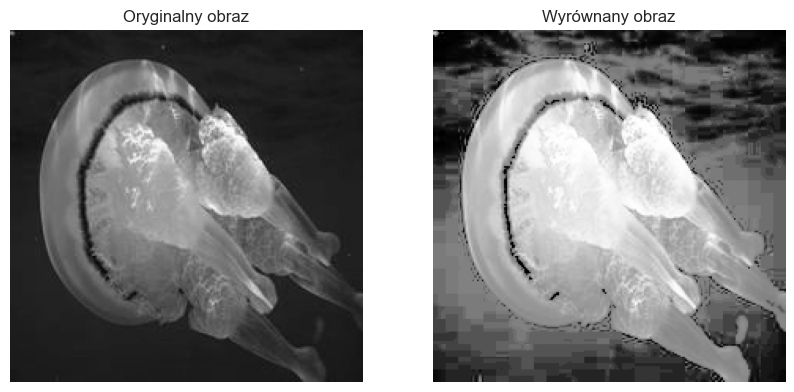

Przetwarzanie obrazów:   0%|          | 1/956 [00:00<04:08,  3.85it/s]

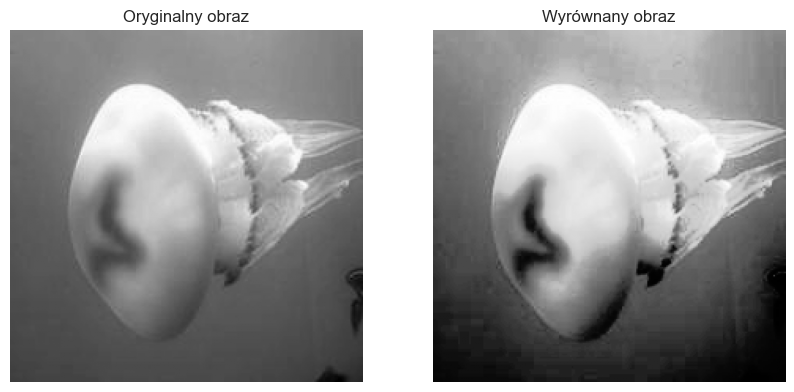

Przetwarzanie obrazów:   0%|          | 2/956 [00:00<03:48,  4.18it/s]

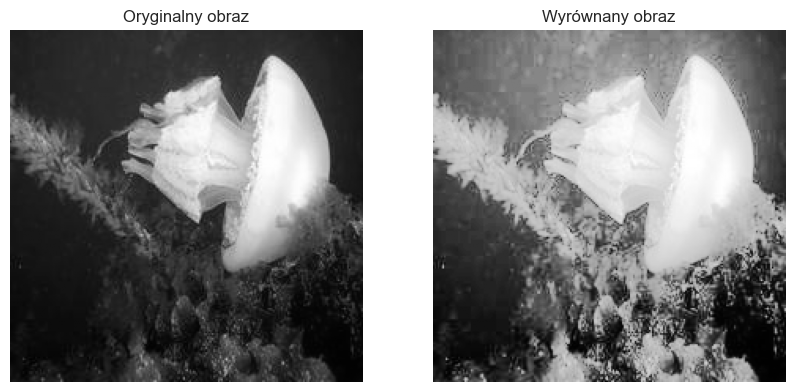

Przetwarzanie obrazów:   0%|          | 3/956 [00:00<03:58,  3.99it/s]

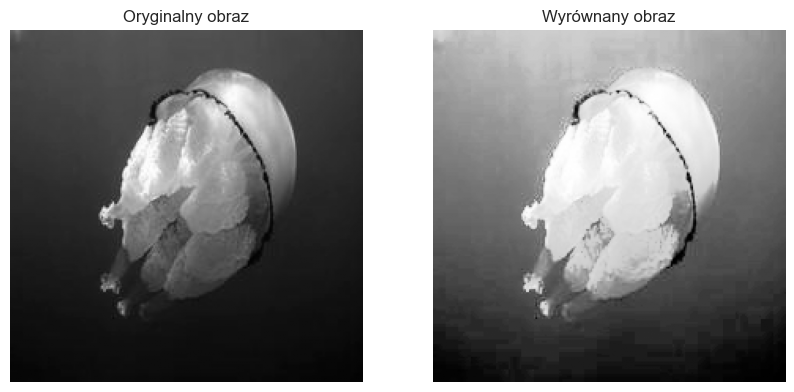

Przetwarzanie obrazów:   0%|          | 4/956 [00:01<06:22,  2.49it/s]

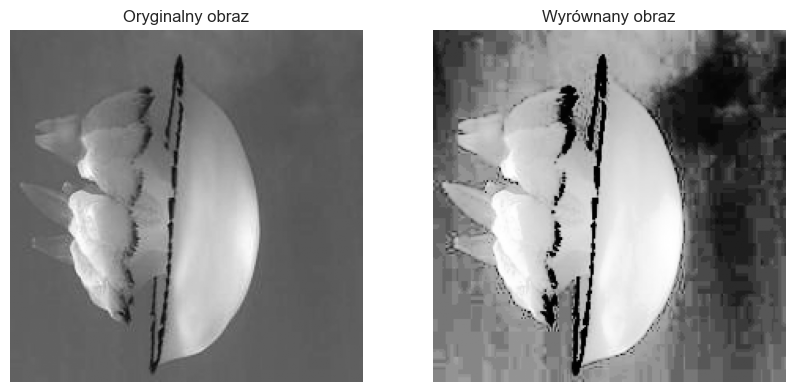

Przetwarzanie obrazów: 100%|██████████| 956/956 [00:03<00:00, 251.95it/s]


In [21]:
#Wyrównanie histogramu – poprawi kontrast obrazu i pomoże w rozciągnięciu zakresu jasności, szczególnie w przypadku ciemniejszych obrazów.

from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ścieżki
input_base = Path("DATA/Standardized_Copy")
output_base = Path("DATA/Equalized_Copy")
image_paths = list(input_base.rglob("*.jpg"))

# Liczba przykładów do wyświetlenia
num_images_to_display = 5
shown = 0

if len(image_paths) == 0:
    print("Brak obrazów w katalogu.")
else:
    print(f"Znaleziono {len(image_paths)} obrazów.")

# Przetwarzanie
for img_path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Nie można wczytać: {img_path}")
        continue

    # Skala szarości i wyrównanie histogramu
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)

    # Zapis do równoległego folderu
    relative_path = img_path.relative_to(input_base)
    output_path = output_base / relative_path
    output_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(output_path), equalized_image)

    # Pokazanie tylko kilku przykładów
    if shown < num_images_to_display:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(gray_image, cmap='gray')
        plt.title("Oryginalny obraz")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(equalized_image, cmap='gray')
        plt.title("Wyrównany obraz")
        plt.axis('off')
        plt.show()

        shown += 1



📁 Przetwarzanie obrazów: (956 obrazów)


Przetwarzanie obrazów: 100%|██████████| 956/956 [00:00<00:00, 985.81it/s] 


Średnia jasność w całym zbiorze: 133.20
Minimalna jasność w zbiorze: 34.15
Maksymalna jasność w zbiorze: 210.43


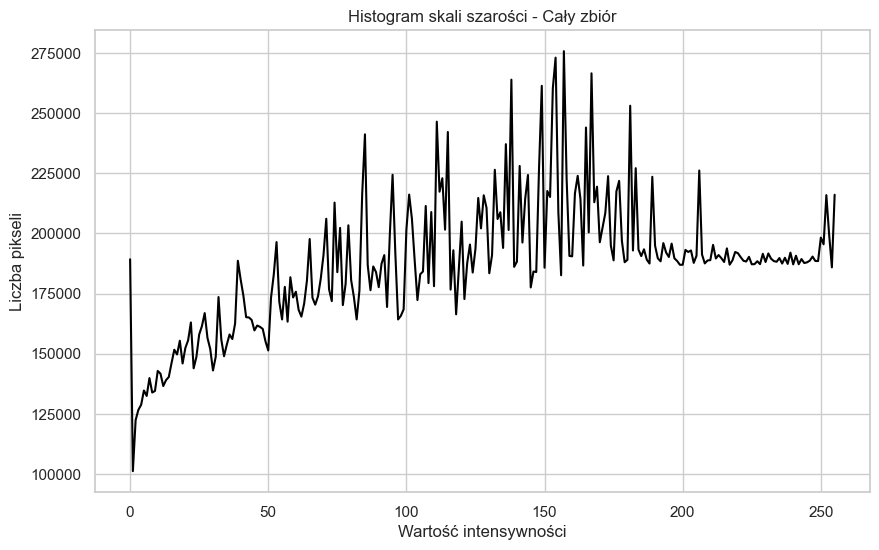

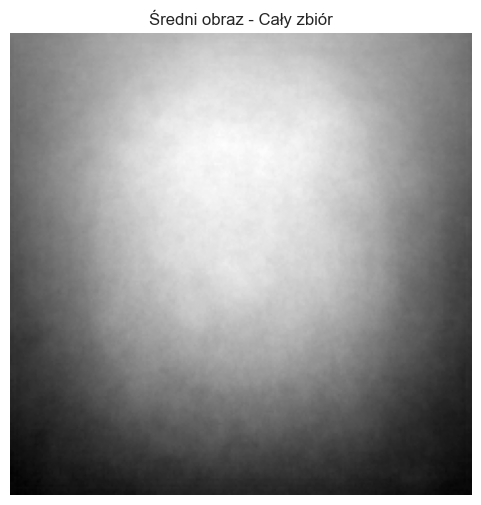

In [30]:
# Ścieżki wejściowe
input_base = Path("DATA/Equalized_Copy")

# Inicjalizacja zmiennych
brightness_vals = []
average_image = None  # Średni obraz dla całego zbioru
gray_hist_total = np.zeros((256, 1))  # Histogram skali szarości (0-255)

# Wyszukaj wszystkie obrazy w katalogu "Standardized" (rekursywnie)
image_paths = list(input_base.rglob("*.jpg"))  # Wyszukaj obrazy .jpg w podkatalogach

print(f"\n📁 Przetwarzanie obrazów: ({len(image_paths)} obrazów)")

# Zmienna do przechowywania minimalnej i maksymalnej jasności
min_brightness = float('inf')
max_brightness = float('-inf')

for img_path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Nie można wczytać: {img_path}")
        continue
    
    # Konwersja do skali szarości
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Obliczanie średniej jasności
    brightness = np.mean(gray_image)
    brightness_vals.append(brightness)

    # Aktualizacja minimalnej i maksymalnej jasności
    min_brightness = min(min_brightness, brightness)
    max_brightness = max(max_brightness, brightness)

    # Histogram skali szarości
    gray_hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    gray_hist_total += gray_hist  # Zbieranie histogramu

    # Obliczanie średniego obrazu
    if average_image is None:
        average_image = np.zeros_like(gray_image, dtype=np.float64)
    average_image += gray_image / len(image_paths)

# Przekształcenie średniego obrazu na uint8
average_image = average_image.astype(np.uint8)

# Wyświetlanie statystyk
print(f"Średnia jasność w całym zbiorze: {np.mean(brightness_vals):.2f}")
print(f"Minimalna jasność w zbiorze: {min_brightness:.2f}")
print(f"Maksymalna jasność w zbiorze: {max_brightness:.2f}")

# Wyświetlanie histogramu skali szarości
plt.figure(figsize=(10, 6))
plt.plot(gray_hist_total, color='black')
plt.title("Histogram skali szarości - Cały zbiór")
plt.xlabel('Wartość intensywności')
plt.ylabel('Liczba pikseli')
plt.show()

# Wyświetlanie średniego obrazu dla całego zbioru
plt.figure(figsize=(6, 6))
plt.imshow(average_image, cmap='gray')
plt.title("Średni obraz - Cały zbiór")
plt.axis('off')
plt.show()

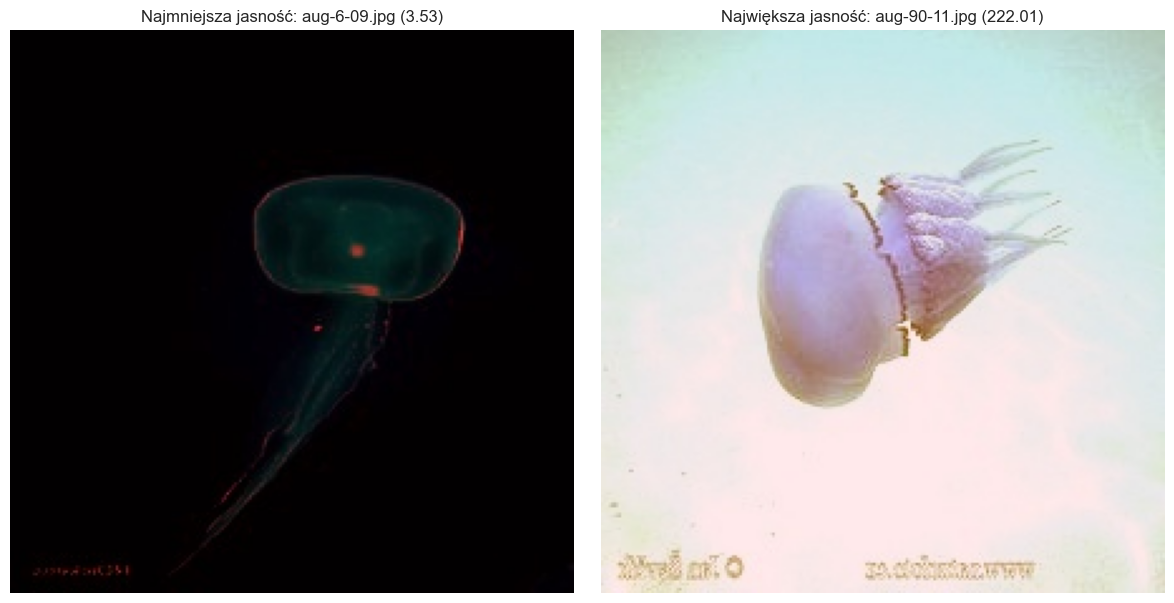

In [ ]:
#Rozpatrzenie jasności dla kolorowych zdjęć i zastosowanie tej samej techniki
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Ścieżka do folderu z obrazami
input_base = Path("DATA/Standardized2_Resized")

# Pobieranie ścieżek do wszystkich obrazów .jpg
image_paths = list(input_base.rglob("*.jpg"))

# Funkcja obliczająca średnią jasność obrazu na podstawie kanałów RGB
def calculate_brightness(image):
    # Obliczanie jasności jako średnia z kanałów R, G, B
    return np.mean(image)

# Zmienna do przechowywania informacji o najmniejszej i największej jasności
min_brightness = float('inf')
max_brightness = float('-inf')
min_brightness_img_path = None
max_brightness_img_path = None

# Przeszukiwanie obrazów i obliczanie jasności
for img_path in image_paths:
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    # Obliczanie jasności obrazu
    brightness = calculate_brightness(img)

    # Aktualizacja obrazu o najmniejszej jasności
    if brightness < min_brightness:
        min_brightness = brightness
        min_brightness_img_path = img_path

    # Aktualizacja obrazu o największej jasności
    if brightness > max_brightness:
        max_brightness = brightness
        max_brightness_img_path = img_path

# Wczytanie obrazów o najmniejszej i największej jasności
min_img = cv2.imread(str(min_brightness_img_path))
max_img = cv2.imread(str(max_brightness_img_path))

# Konwersja do RGB (OpenCV używa BGR, więc musimy przekształcić do RGB)
min_img_rgb = cv2.cvtColor(min_img, cv2.COLOR_BGR2RGB)
max_img_rgb = cv2.cvtColor(max_img, cv2.COLOR_BGR2RGB)

# Wyświetlenie obrazów
plt.figure(figsize=(12, 6))

# Obraz o najmniejszej jasności
plt.subplot(1, 2, 1)
plt.imshow(min_img_rgb)
plt.title(f"Najmniejsza jasność: {min_brightness_img_path.name} ({min_brightness:.2f})")
plt.axis('off')

# Obraz o największej jasności
plt.subplot(1, 2, 2)
plt.imshow(max_img_rgb)
plt.title(f"Największa jasność: {max_brightness_img_path.name} ({max_brightness:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()


Znaleziono 956 obrazów.


Przetwarzanie obrazów:   0%|          | 0/956 [00:00<?, ?it/s]

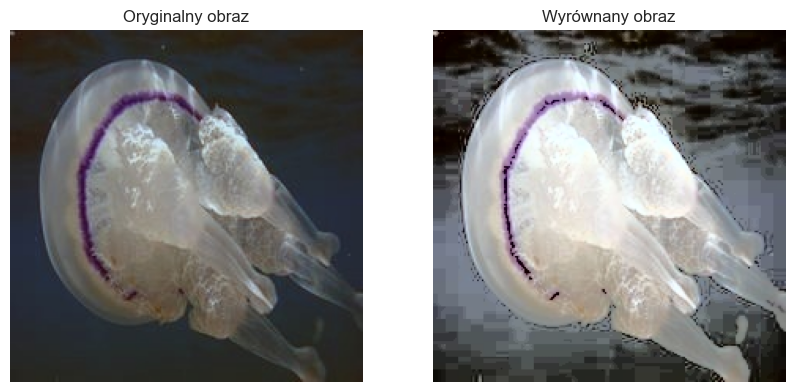

Przetwarzanie obrazów:   0%|          | 1/956 [00:00<08:39,  1.84it/s]

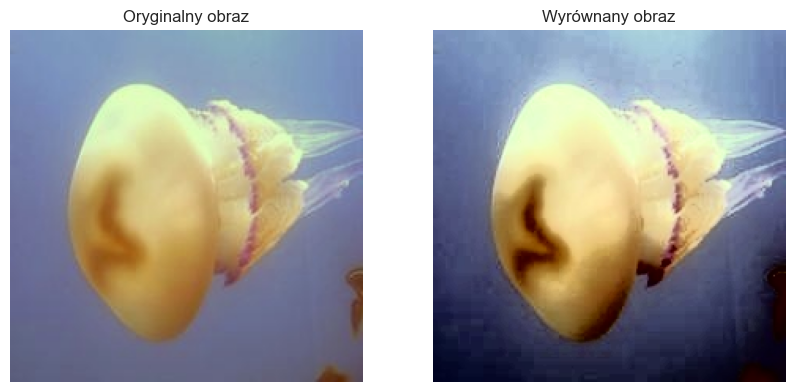

Przetwarzanie obrazów:   0%|          | 2/956 [00:00<05:34,  2.85it/s]

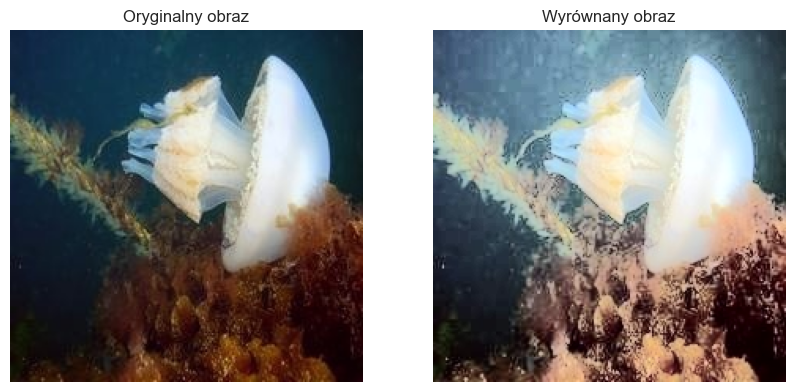

Przetwarzanie obrazów:   0%|          | 3/956 [00:00<04:41,  3.39it/s]

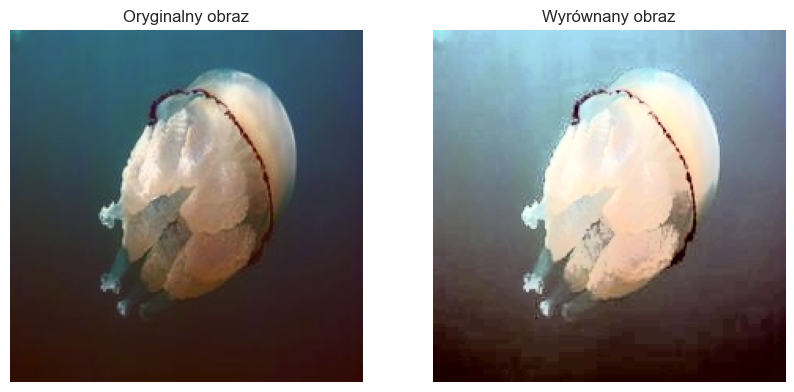

Przetwarzanie obrazów:   0%|          | 4/956 [00:01<04:08,  3.83it/s]

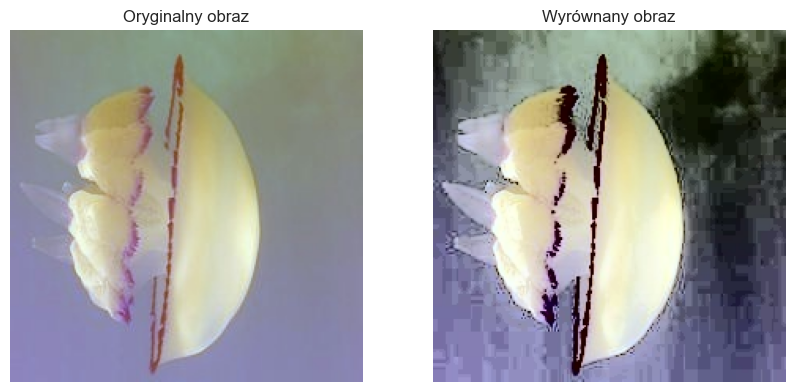

Przetwarzanie obrazów: 100%|██████████| 956/956 [00:03<00:00, 251.01it/s]


In [32]:
# Ścieżki wejściowe
input_base = Path("DATA/Standardized2_Resized")
output_base = Path("DATA/Equalized2_Color")
image_paths = list(input_base.rglob("*.jpg"))

# Liczba przykładów do wyświetlenia
num_images_to_display = 5
shown = 0

if len(image_paths) == 0:
    print("Brak obrazów w katalogu.")
else:
    print(f"Znaleziono {len(image_paths)} obrazów.")

# Przetwarzanie
for img_path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Nie można wczytać: {img_path}")
        continue

    # Konwersja do przestrzeni kolorów YUV
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # Wyrównanie histogramu tylko w kanale Y (jasność)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # Konwersja z powrotem do przestrzeni kolorów BGR
    equalized_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    # Zapis do równoległego folderu
    relative_path = img_path.relative_to(input_base)
    output_path = output_base / relative_path
    output_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(output_path), equalized_image)

    # Pokazanie tylko kilku przykładów
    if shown < num_images_to_display:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Oryginalny obraz")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
        plt.title("Wyrównany obraz")
        plt.axis('off')
        plt.show()

        shown += 1


CLAHE (Contrast Limited Adaptive Histogram Equalization) to technika poprawy kontrastu, która działa na lokalnych fragmentach obrazu, a nie na całym obrazie jednocześnie. Dzięki temu może poprawić szczegóły w ciemnych lub jasnych częściach obrazu, nie powodując przepaści w innych jego częściach. Jest to szczególnie przydatne w obrazach, które mają dużą różnicę jasności w różnych obszarach.

Główne zalety CLAHE:

Poprawa kontrastu: Zwiększa kontrast szczególnie w obszarach o niskim kontraście.

Brak przepaleń: Ogranicza nadmierne wyostrzenie, które może wystąpić w klasycznym wyrównaniu histogramu.

Lokalna poprawa: Zamiast zmieniać cały obraz, CLAHE działa lokalnie, poprawiając różne obszary obrazu w zależności od ich charakterystyki.

Znaleziono 956 obrazów.


CLAHE na kolorowych obrazach: 100%|██████████| 956/956 [00:03<00:00, 265.23it/s]


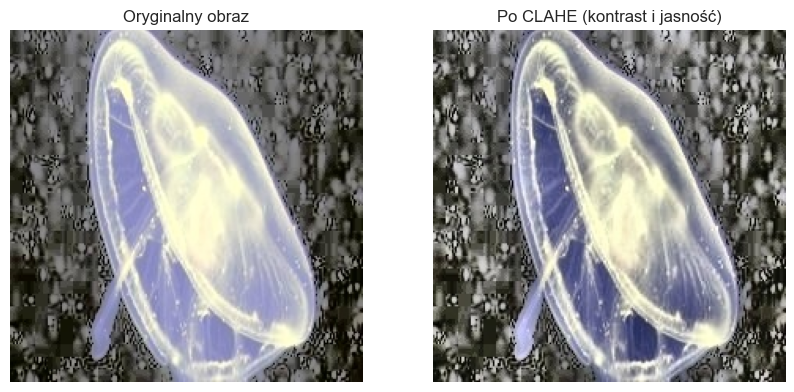

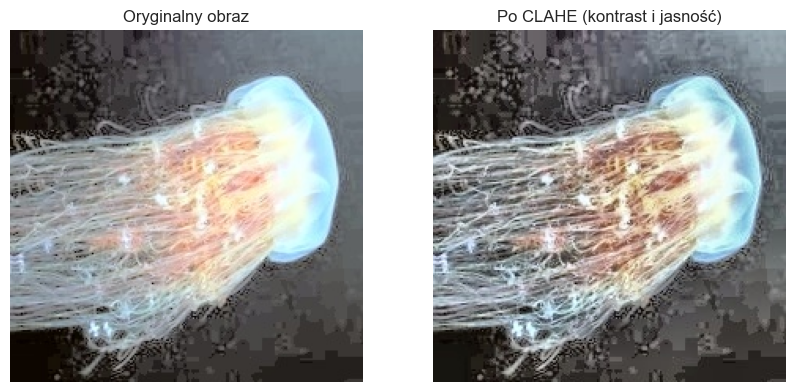

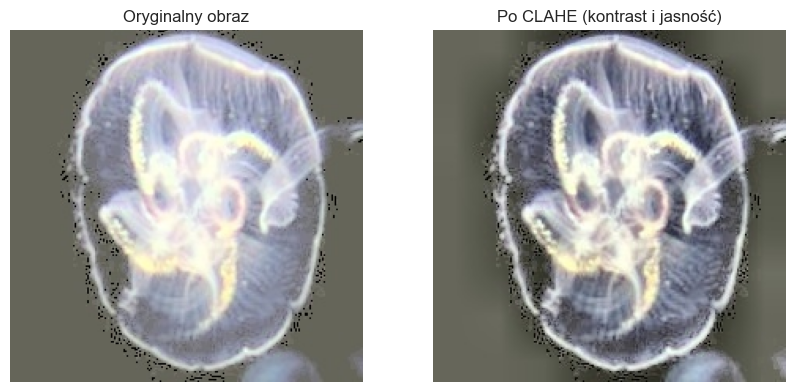

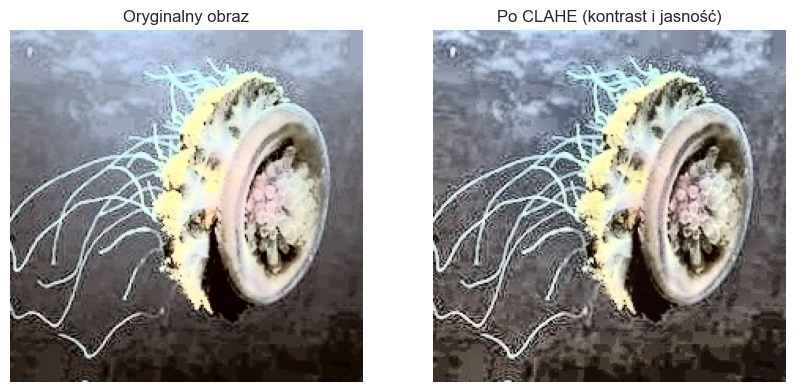

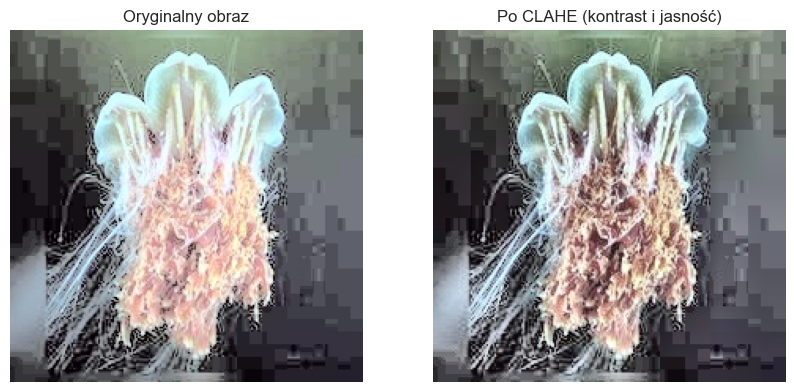

In [33]:
#Poprawa jasności i kontrastu kolorów w obrazach RGB
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Ścieżki
input_base = Path("DATA/Equalized2_Color")
output_base = Path("DATA/CLAHE_Color")
output_base.mkdir(parents=True, exist_ok=True)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Wczytanie ścieżek
image_paths = list(input_base.rglob("*.jpg"))
print(f"Znaleziono {len(image_paths)} obrazów.")

for img_path in tqdm(image_paths, desc="CLAHE na kolorowych obrazach"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Nie można wczytać: {img_path}")
        continue

    # Konwersja do LAB (lepsze dla jasności)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Wyrównanie histogramu tylko na kanale L (jasność)
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))

    # Konwersja z powrotem do BGR
    enhanced_img = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    # Zapis
    relative_path = img_path.relative_to(input_base)
    output_path = output_base / relative_path
    output_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(output_path), enhanced_img)

# ✅ Pokazanie kilku przykładów
import random
sample_paths = random.sample(image_paths, 5)

for path in sample_paths:
    original = cv2.imread(str(path))
    enhanced = cv2.imread(str(output_base / path.relative_to(input_base)))

    # Konwersja do RGB do wyświetlenia
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title("Oryginalny obraz")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_rgb)
    plt.title("Po CLAHE (kontrast i jasność)")
    plt.axis('off')

    plt.show()


Rotacja o małe kąty (np. 10°, 20°): Może pomóc w lepszym generalizowaniu modelu, jeśli meduza na obrazie może występować w różnej orientacji.
Nie decyduję się na odbicie lustrzane bo meduzy często są asymetryczne.

In [34]:
#Rotacja obrazów o małe kąty (np. 5°, 10°, 15°) w celu zwiększenia różnorodności zbioru danych
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Ścieżki wejściowe i wyjściowe
input_base = Path("DATA/CLAHE_Color")  # Katalog z oryginalnymi zdjęciami
output_base = Path("DATA/Rotated")  # Katalog na przetworzone zdjęcia
output_base.mkdir(parents=True, exist_ok=True)

# Funkcja do rotacji obrazu o małe kąty
def rotate_image(img, angle):
    # Wymiary obrazu
    (h, w) = img.shape[:2]
    # Centrum obrotu
    center = (w // 2, h // 2)
    # Generowanie macierzy rotacji
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Rotacja obrazu
    rotated_image = cv2.warpAffine(img, rotation_matrix, (w, h))
    return rotated_image

# Wczytanie obrazów
image_paths = list(input_base.rglob("*.jpg"))

# Kąty rotacji (np. 5°, 10°, 15°)
rotation_angles = [5, 10, 15, 20, 25]  # Można dodać więcej kątów

# Przetwarzanie obrazów
for img_path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Nie można wczytać: {img_path}")
        continue

    # Zastosowanie rotacji o różne kąty
    for angle in rotation_angles:
        rotated_img = rotate_image(img, angle)

        # Ścieżka wyjściowa
        relative_path = img_path.relative_to(input_base)
        output_path = output_base / relative_path.parent
        output_path.mkdir(parents=True, exist_ok=True)

        # Zapisz rotowany obraz
        rotated_image_name = f"rotated_{angle}_{img_path.name}"
        cv2.imwrite(str(output_path / rotated_image_name), rotated_img)

print("Rotacja zakończona. Przetworzone obrazy zostały zapisane.")


Przetwarzanie obrazów: 100%|██████████| 956/956 [00:11<00:00, 82.97it/s]

Rotacja zakończona. Przetworzone obrazy zostały zapisane.


Znaleziono 4780 obrazów.


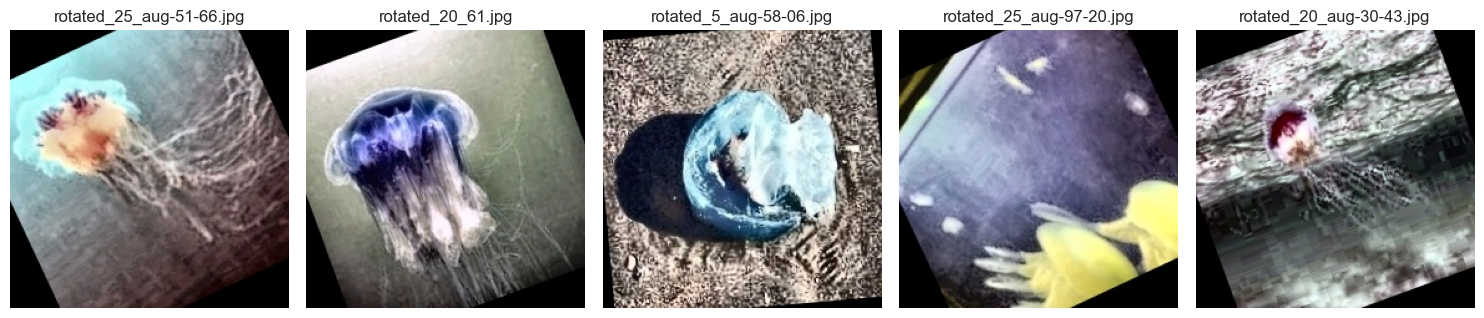

In [35]:
#Wyswietlenie kilku przykładowych obrazów po rotacji

# Ścieżka do folderu z nowymi obrazami
input_base = Path("DATA/Rotated")

# Pobieranie wszystkich ścieżek do obrazów
image_paths = list(input_base.rglob("*.jpg"))

# Liczba obrazów do wyświetlenia
num_images_to_display = 5

# Sprawdzamy, czy obrazy zostały znalezione
if len(image_paths) == 0:
    print("Brak obrazów w katalogu.")
else:
    print(f"Znaleziono {len(image_paths)} obrazów.")

# Wybieramy losowe obrazy do wyświetlenia
sample_images = random.sample(image_paths, num_images_to_display)

# Wyświetlanie wybranych obrazów
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konwersja z BGR na RGB

    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img_rgb)
    plt.title(img_path.name)
    plt.axis('off')

plt.tight_layout()
plt.show()
